<a href="https://colab.research.google.com/github/joaomottin/DataScienceLab/blob/main/GraficoYelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

uploaded = files.upload()


Saving yelp_labelled.txt to yelp_labelled.txt


In [2]:
df = pd.read_csv(io.BytesIO(uploaded['yelp_labelled.txt']),sep = '\t')
print(df)

                                                  text  target
0                             Wow... Loved this place.       1
1                                   Crust is not good.       0
2            Not tasty and the texture was just nasty.       0
3    Stopped by during the late May bank holiday of...       1
4    The selection on the menu was great and so wer...       1
..                                                 ...     ...
995  I think food should have flavor and texture an...       0
996                           Appetite instantly gone.       0
997  Overall I was not impressed and would not go b...       0
998  The whole experience was underwhelming, and I ...       0
999  Then, as if I hadn't wasted enough of my life ...       0

[1000 rows x 2 columns]


In [3]:
#Mostra a quantidade de linhas e colunas
df.shape

(1000, 2)

In [4]:
df.groupby('target')['target'].count()

,target
target,
0,500
1,500


In [5]:
print("\nVerificando balanceamento:")
contagem_classes = df.groupby('target')['target'].count()
total = contagem_classes.sum()
porcentagem_classes = contagem_classes / total * 100
print(porcentagem_classes)


# Separamos os dados para treino e test
from sklearn.model_selection import train_test_split
X = df['text']
y = df['target']

#Embaralhamos os dados sendo 25% para teste e 75% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"\nTamanho do Treino: {len(X_train)} amostras")
print(f"Tamanho do Teste: {len(X_test)} amostras")


Verificando balanceamento:
target
0    50.0
1    50.0
Name: target, dtype: float64

Tamanho do Treino: 750 amostras
Tamanho do Teste: 250 amostras


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Baixa uma lista de palavras que não tem peso para frases (stopwords)
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Inicializa o vetorizador
vectorizer = TfidfVectorizer(stop_words=stop_words)

# Aprende o vocabulário e transforma os dados de TREINO
X_train_tfidf = vectorizer.fit_transform(X_train)

# Apenas transforma os dados de TESTE (usando o vocabulário do treino)
X_test_tfidf = vectorizer.transform(X_test)

print(f"\nShape da matriz TF-IDF (Treino): {X_train_tfidf.shape}")


Shape da matriz TF-IDF (Treino): (750, 1605)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
# --- 4. OTIMIZAÇÃO DE HIPERPARÂMETROS (Grid Search) (Item v) ---

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

print("\n--- Iniciando Otimização (Grid Search) ---")

# --- 4.1 Otimização para RandomForest ---
print("Iniciando Grid Search para RandomForest...")

# Define os parâmetros que queremos testar
param_grid_rf = {
    'n_estimators': [100, 200],         # Número de árvores
    'max_depth': [None, 30],            # Profundidade máxima
    'min_samples_leaf': [1, 2]          # Mínimo de amostras por folha
}

# Cria o objeto GridSearchCV
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3, # 3-fold cross-validation (mais rápido)
                              n_jobs=-1, # Usar todos os processadores
                              scoring='f1') # Otimizar pelo F1-score

# Executa a busca nos dados de treino
grid_search_rf.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de RandomForest encontrado
model = grid_search_rf.best_estimator_

print(f"Melhores parâmetros para RandomForest: {grid_search_rf.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_rf.best_score_:.4f}")


# --- 4.2 Otimização para Regressão Logística ---
print("\nIniciando Grid Search para Regressão Logística...")

# Define os parâmetros para testar
param_grid_lr = {
    'C': [0.1, 1.0, 10.0],           # Força da regularização
    'solver': ['liblinear', 'saga'],  # Algoritmos de otimização
    'penalty': ['l1', 'l2']           # Tipo de regularização
}

# Cria o objeto GridSearchCV
grid_search_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                              param_grid=param_grid_lr,
                              cv=3,
                              n_jobs=-1,
                              scoring='f1')

# Executa a busca nos dados de treino
grid_search_lr.fit(X_train_tfidf, y_train)

# Pega o MELHOR modelo de Regressão Logística encontrado
lr_model = grid_search_lr.best_estimator_

print(f"Melhores parâmetros para Regressão Logística: {grid_search_lr.best_params_}")
print(f"Melhor F1-score (validação): {grid_search_lr.best_score_:.4f}")


--- Iniciando Otimização (Grid Search) ---
Iniciando Grid Search para RandomForest...
Melhores parâmetros para RandomForest: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 100}
Melhor F1-score (validação): 0.7250

Iniciando Grid Search para Regressão Logística...
Melhores parâmetros para Regressão Logística: {'C': 10.0, 'penalty': 'l2', 'solver': 'saga'}
Melhor F1-score (validação): 0.7616


In [8]:
# --- 5. AVALIAÇÃO DOS MODELOS OTIMIZADOS (Item vi) ---

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)

print("\n--- Avaliação de Performance dos Modelos Otimizados ---")

# --- 5.1 Previsões (com os modelos otimizados) ---

# RandomForest
y_pred = model.predict(X_test_tfidf)
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo (classe 1)

# Regressão Logística
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1] # Probabilidades de ser positivo

# --- 5.2 Cálculo das Métricas ---

# Métricas para o RandomForest
print("\nRandom Forest (Otimizado):")
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_auc_roc = roc_auc_score(y_test, y_pred_proba)
rf_auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Acurácia: {rf_accuracy:.4f}")
print(f"Precisão: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc_roc:.4f}")
print(f"AUC-PR (AP): {rf_auc_pr:.4f}")

# Métricas para a Regressão Logística
print("\nRegressão Logística (Otimizada):")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc_roc = roc_auc_score(y_test, y_pred_proba_lr)
lr_auc_pr = average_precision_score(y_test, y_pred_proba_lr)

print(f"Acurácia: {lr_accuracy:.4f}")
print(f"Precisão: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"AUC-ROC: {lr_auc_roc:.4f}")
print(f"AUC-PR (AP): {lr_auc_pr:.4f}")


--- Avaliação de Performance dos Modelos Otimizados ---

Random Forest (Otimizado):
Acurácia: 0.7280
Precisão: 0.7812
Recall: 0.6148
F1-Score: 0.6881
AUC-ROC: 0.8221
AUC-PR (AP): 0.8269

Regressão Logística (Otimizada):
Acurácia: 0.8000
Precisão: 0.8051
Recall: 0.7787
F1-Score: 0.7917
AUC-ROC: 0.8374
AUC-PR (AP): 0.8374



Plotando curvas de avaliação com pontos de corte ótimos...


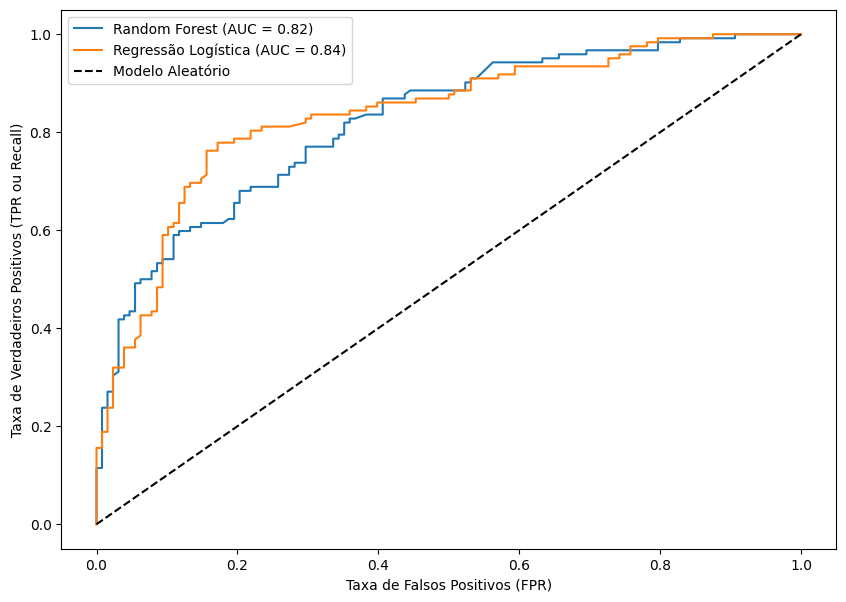

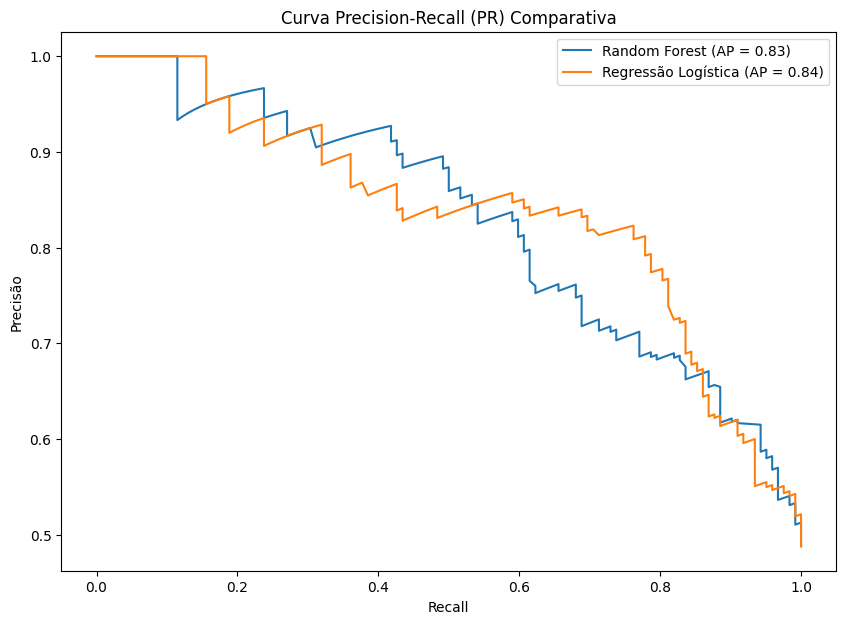

In [9]:
# --- 5.3 Plotar Curvas ROC e PR (COM PONTO DE CORTE ÓTIMO) ---

print("\nPlotando curvas de avaliação com pontos de corte ótimos...")

# --- Curva ROC ---

# 1. Calcular dados para RandomForest (agora salvando os 'thresholds_rf')
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba)


# 2. Calcular dados para Regressão Logística (salvando 'thresholds_lr')
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)

# 3. Plotar o gráfico ROC com os pontos
plt.figure(figsize=(10, 7))
# Plot das curvas
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc_roc:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {lr_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório') # Linha de referência


plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.legend()
plt.show()


# --- Curva PR (Precision-Recall) ---
# (Este código continua o mesmo de antes, mas está incluído para facilitar a cópia)

precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {rf_auc_pr:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Regressão Logística (AP = {lr_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (PR) Comparativa')
plt.legend()
plt.show()


--- Análise de Pontos de Corte (Usando RandomForest) ---


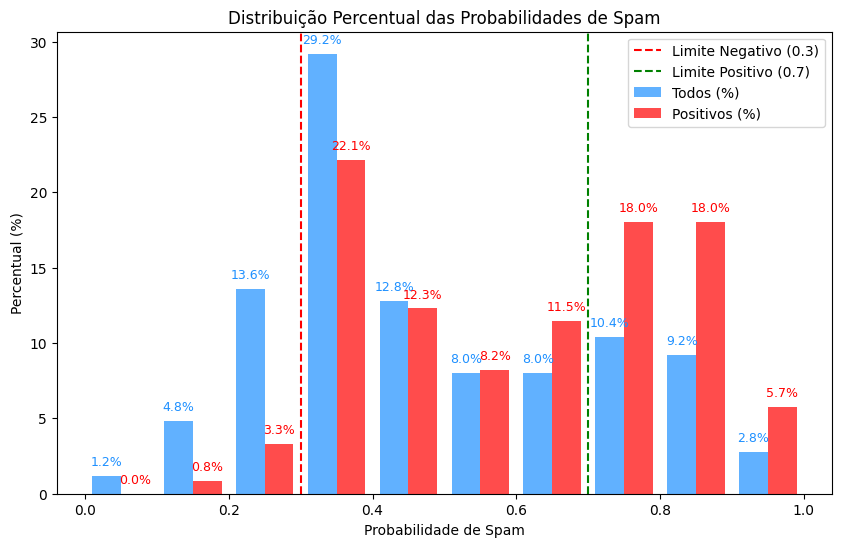

Avaliando métricas para os cortes 0.3 e 0.7...

Corte 0.3
Accuracy: 0.644
Precision: 0.582089552238806
Recall: 0.9590163934426229
F1: 0.7244582043343654

Corte 0.7
Accuracy: 0.696
Precision: 0.9107142857142857
Recall: 0.4180327868852459
F1: 0.5730337078651685

Divisão por Zonas (Negativa / Manual / Positiva):
zone
manual      58.0
positiva    22.4
negativa    19.6
Name: proportion, dtype: float64


In [13]:
# --- 6. ANÁLISE DE PONTOS DE CORTE (Item vii) ---
# (Usando o melhor modelo. Vamos assumir que foi o RandomForest 'model')

print("\n--- Análise de Pontos de Corte (Usando RandomForest) ---")

#Pega as probabilidades de ser positivo
positive_probs = y_pred_proba # Já calculamos isso antes

#Organiza todas as probabilidades de ser positivo junto do target (y_test)
df_pos = pd.DataFrame({"prob_spam": positive_probs, "target": y_test.values})

#Separa apenas para os que são positivos
df_apenas_positivo = df_pos.loc[df_pos['target']==1]

#Cria as caixas (bins) de 10% em 10% porcento
step = 0.1
bins = np.arange(0, 1 + step, step)

#Faz a contagem de todas as probabilidades
hist_all, _ = np.histogram(df_pos["prob_spam"], bins=bins)
#Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos, _ = np.histogram(df_apenas_positivo["prob_spam"], bins=bins)

# Convertendo para percentual (%)
# (Adicionado .sum() para evitar divisão por zero se um bin estiver vazio)
hist_all_pct = (hist_all / (hist_all.sum() + 1e-9)) * 100
hist_pos_pct = (hist_pos / (hist_pos.sum() + 1e-9)) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', color='red', alpha=0.7)

for xi, val_all, val_pos in zip(x, hist_all_pct, hist_pos_pct):
    # Texto da população total (azul)
    plt.text(xi - width/2, val_all + 0.5, f"{val_all:.1f}%", ha='center', va='bottom', fontsize=9, color='#1E90FF')
    # Texto dos positivos (vermelho)
    plt.text(xi + width/2, val_pos + 0.5, f"{val_pos:.1f}%", ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam')

# Pontos de corte customizáveis
threshold_neg = 0.3
threshold_pos = 0.7
plt.axvline(threshold_neg, color='red', linestyle='--', label=f'Limite Negativo ({threshold_neg})')
plt.axvline(threshold_pos, color='green', linestyle='--', label=f'Limite Positivo ({threshold_pos})')

plt.legend()
plt.show()

# --- 6.1 Métricas para os pontos de corte ---
print(f"Avaliando métricas para os cortes {threshold_neg} e {threshold_pos}...")

# Corte 0.2 -> considera como positivo apenas prob > 0.2
y_pred_02 = (df_pos["prob_spam"] > threshold_neg).astype(int)

# Corte 0.4 -> considera como positivo prob >= 0.4
y_pred_04 = (df_pos["prob_spam"] >= threshold_pos).astype(int)

# métricas para corte 0.4
print(f"\nCorte {threshold_neg}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_02))
print("Precision:", precision_score(df_pos["target"], y_pred_02))
print("Recall:", recall_score(df_pos["target"], y_pred_02))
print("F1:", f1_score(df_pos["target"], y_pred_02))

# métricas para corte 0.7
print(f"\nCorte {threshold_pos}")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_04))
print("Precision:", precision_score(df_pos["target"], y_pred_04))
print("Recall:", recall_score(df_pos["target"], y_pred_04))
print("F1:", f1_score(df_pos["target"], y_pred_04))

# --- 6.2 Divisão em Zonas ---
def assign_zone(prob):
    if prob <= threshold_neg:
        return "negativa"
    elif prob >= threshold_pos:
        return "positiva"
    else:
        return "manual"

#Usa a função para cada uma das probabilidades
df_pos["zone"] = df_pos["prob_spam"].apply(assign_zone)

# Ver quantos exemplos vão para cada zona
print("\nDivisão por Zonas (Negativa / Manual / Positiva):")
print(df_pos["zone"].value_counts(normalize=True) * 100)


--- Análise de Pontos de Corte (Usando Regressão Logística) ---


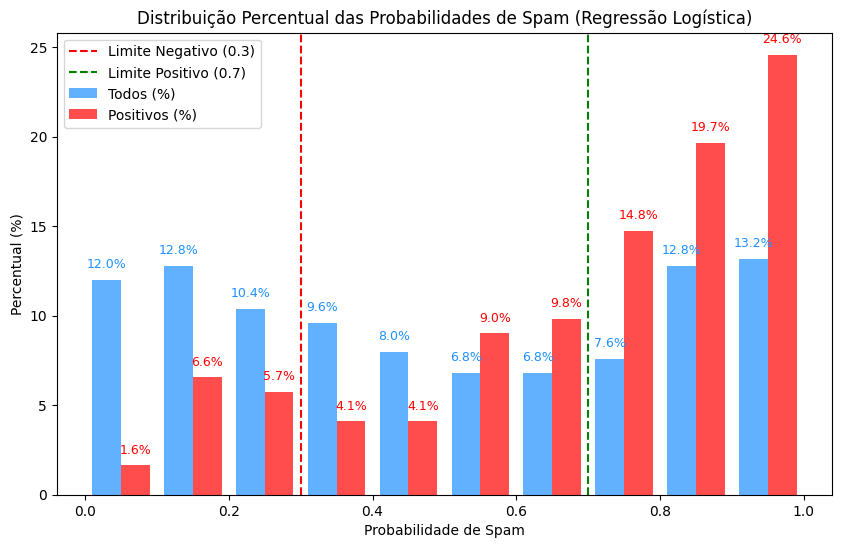

Avaliando métricas para os cortes 0.3 e 0.7...

Corte 0.3
Accuracy: 0.704
Precision: 0.6481481481481481
Recall: 0.860655737704918
F1: 0.7394366197183099

Corte 0.7
Accuracy: 0.752
Precision: 0.8571428571428571
Recall: 0.5901639344262295
F1: 0.6990291262135923

Divisão por Zonas (Negativa / Manual / Positiva):
zone
negativa    35.2
positiva    33.6
manual      31.2
Name: proportion, dtype: float64


In [14]:
# --- 6. ANÁLISE DE PONTOS DE CORTE (Usando Regressão Logística) ---

print("\n--- Análise de Pontos de Corte (Usando Regressão Logística) ---")

# Pega as probabilidades de ser positivo
positive_probs_lr = y_pred_proba_lr  # já calculadas acima

# Organiza todas as probabilidades de ser positivo junto do target
df_pos_lr = pd.DataFrame({"prob_spam": positive_probs_lr, "target": y_test.values})

# Separa apenas os que são realmente positivos
df_apenas_positivo_lr = df_pos_lr.loc[df_pos_lr['target'] == 1]

# Cria as caixas (bins) de 10% em 10%
step = 0.1
bins = np.arange(0, 1 + step, step)

# Faz a contagem de todas as probabilidades
hist_all_lr, _ = np.histogram(df_pos_lr["prob_spam"], bins=bins)
# Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos_lr, _ = np.histogram(df_apenas_positivo_lr["prob_spam"], bins=bins)

# Convertendo para percentual (%)
hist_all_pct_lr = (hist_all_lr / (hist_all_lr.sum() + 1e-9)) * 100
hist_pos_pct_lr = (hist_pos_lr / (hist_pos_lr.sum() + 1e-9)) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, hist_all_pct_lr, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct_lr, width=width, label='Positivos (%)', color='red', alpha=0.7)

# Adiciona o percentual acima das barras (ambos)
for xi, val_all, val_pos in zip(x, hist_all_pct_lr, hist_pos_pct_lr):
    plt.text(xi - width/2, val_all + 0.5, f"{val_all:.1f}%", ha='center', va='bottom', fontsize=9, color='#1E90FF')
    plt.text(xi + width/2, val_pos + 0.5, f"{val_pos:.1f}%", ha='center', va='bottom', fontsize=9, color='red')

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam (Regressão Logística)')

# Pontos de corte customizáveis (mesmos do RandomForest)
threshold_neg = 0.3
threshold_pos = 0.7
plt.axvline(threshold_neg, color='red', linestyle='--', label=f'Limite Negativo ({threshold_neg})')
plt.axvline(threshold_pos, color='green', linestyle='--', label=f'Limite Positivo ({threshold_pos})')

plt.legend()
plt.show()

# --- 6.1 Métricas para os pontos de corte ---
print(f"Avaliando métricas para os cortes {threshold_neg} e {threshold_pos}...")

# Corte 0.4
y_pred_04_lr = (df_pos_lr["prob_spam"] > threshold_neg).astype(int)
# Corte 0.7
y_pred_07_lr = (df_pos_lr["prob_spam"] >= threshold_pos).astype(int)

# Métricas para corte 0.4
print(f"\nCorte {threshold_neg}")
print("Accuracy:", accuracy_score(df_pos_lr["target"], y_pred_04_lr))
print("Precision:", precision_score(df_pos_lr["target"], y_pred_04_lr))
print("Recall:", recall_score(df_pos_lr["target"], y_pred_04_lr))
print("F1:", f1_score(df_pos_lr["target"], y_pred_04_lr))

# Métricas para corte 0.7
print(f"\nCorte {threshold_pos}")
print("Accuracy:", accuracy_score(df_pos_lr["target"], y_pred_07_lr))
print("Precision:", precision_score(df_pos_lr["target"], y_pred_07_lr))
print("Recall:", recall_score(df_pos_lr["target"], y_pred_07_lr))
print("F1:", f1_score(df_pos_lr["target"], y_pred_07_lr))

# --- 6.2 Divisão em Zonas ---
def assign_zone_lr(prob):
    if prob <= threshold_neg:
        return "negativa"
    elif prob >= threshold_pos:
        return "positiva"
    else:
        return "manual"

# Usa a função para cada uma das probabilidades
df_pos_lr["zone"] = df_pos_lr["prob_spam"].apply(assign_zone_lr)

# Ver quantos exemplos vão para cada zona
print("\nDivisão por Zonas (Negativa / Manual / Positiva):")
print(df_pos_lr["zone"].value_counts(normalize=True) * 100)



--- Top 10 Palavras Mais Importantes (RandomForest) ---
        Palavra  Importancia
621       great     0.091487
611        good     0.042559
366   delicious     0.039110
573    friendly     0.023836
950        nice     0.020520
41      amazing     0.019947
835        love     0.018870
92      awesome     0.016417
1060      place     0.016189
99          bad     0.015912


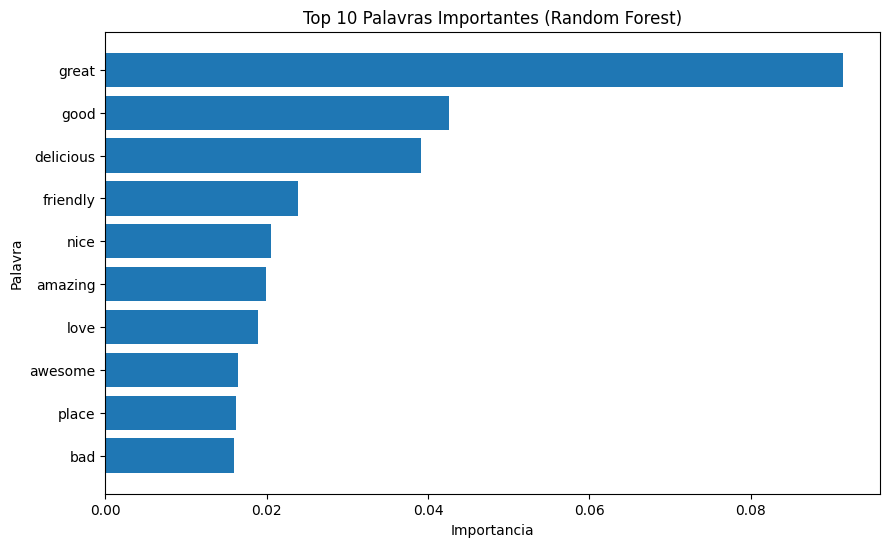

In [15]:
# --- 7. IMPORTÂNCIA DAS FEATURES (PALAVRAS) ---
# (Usando o RandomForest, que tem 'feature_importances_')

print("\n--- Top 10 Palavras Mais Importantes (RandomForest) ---")

#Pega a importancia de cada palavra
importances = model.feature_importances_
#Pega a lista de palavras na mesma ordem
feature_names = vectorizer.get_feature_names_out()

#Cria um dataframe com as palavras e suas notas
feature_importance_df = pd.DataFrame({'Palavra': feature_names, 'Importancia': importances})

#Ordena a tabela pela Importancia
feature_importance_df = feature_importance_df.sort_values('Importancia', ascending=False)

#Quantidade de palavras que queremos
N = 10
print(feature_importance_df.head(N))

#Desenha o gráfico
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Palavra'][:N], feature_importance_df['Importancia'][:N])
plt.xlabel('Importancia')
plt.ylabel('Palavra')
plt.title(f'Top {N} Palavras Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.show()